In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import shap

c:\Users\Azadeh\anaconda3\lib\site-packages\dask\config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [6]:
df = pd.read_csv('../data/flights_delay_cleaned.csv')

Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.


In [7]:
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'TAXI_OUT', 'SCHEDULED_TIME', 'SCHEDULED_DEPARTURE_TIME_OF_DAY',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DEPARTURE_DAY', 'ARRIVAL_DAY',
       'SEASON', 'WEEKEND', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'SCHEDULED_ARRIVAL_TIME_OF_DAY', 'Delay', 'DELAY_REASON'],
      dtype='object')

In [8]:
df.describe()

,MONTH,DAY,DAY_OF_WEEK,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,Delay
count,5.714007e+06,5.714007e+06,5.714007e+06,5.714007e+06,5.714007e+06,5.714007e+06,5.714007e+06,5.714007e+06,5.714007e+06,5.714007e+06
mean,6.547800e+00,1.570759e+01,3.932642e+00,1.606550e+01,1.418940e+02,1.370062e+02,1.135116e+02,8.244569e+02,7.429064e+00,2.466647e+01
std,3.397421e+00,8.774395e+00,1.985967e+00,8.882449e+00,7.531400e+01,7.421108e+01,7.223083e+01,6.086620e+02,5.618952e+00,1.104893e+02
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.800000e+01,1.400000e+01,7.000000e+00,3.100000e+01,1.000000e+00,-1.620000e+02
25%,4.000000e+00,8.000000e+00,2.000000e+00,1.100000e+01,8.500000e+01,8.200000e+01,6.000000e+01,3.730000e+02,4.000000e+00,-1.700000e+01
50%,7.000000e+00,1.600000e+01,4.000000e+00,1.400000e+01,1.230000e+02,1.180000e+02,9.400000e+01,6.500000e+02,6.000000e+00,-7.000000e+00
75%,9.000000e+00,2.300000e+01,6.000000e+00,1.900000e+01,1.740000e+02,1.680000e+02,1.440000e+02,1.065000e+03,9.000000e+00,1.400000e+01
max,1.200000e+01,3.100000e+01,7.000000e+00,2.250000e+02,7.180000e+02,7.660000e+02,6.900000e+02,4.983000e+03,2.480000e+02,5.930000e+03


In [9]:
# Encode categorical features
label_encoders = {}
categorical_features = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 
                        'SCHEDULED_DEPARTURE_TIME_OF_DAY', 'DEPARTURE_DAY', 
                        'ARRIVAL_DAY', 'SEASON', 'SCHEDULED_ARRIVAL_TIME_OF_DAY']

for col in categorical_features:
    df[col] = df[col].astype(str)


In [10]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,SCHEDULED_TIME,...,DEPARTURE_DAY,ARRIVAL_DAY,SEASON,WEEKEND,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,SCHEDULED_ARRIVAL_TIME_OF_DAY,Delay,DELAY_REASON
0,1,1,4,AS,ANC,SEA,00:05:00,23:54:00,21.0,205.0,...,False,False,Winter,False,4.0,04:30:00,04:08:00,Early Morning,-33.0,No Delay
1,1,1,4,AA,LAX,PBI,00:10:00,00:02:00,12.0,280.0,...,False,True,Winter,False,4.0,07:50:00,07:41:00,Morning,-17.0,No Delay
2,1,1,4,US,SFO,CLT,00:20:00,00:18:00,16.0,286.0,...,False,True,Winter,False,11.0,08:06:00,08:11:00,Morning,3.0,ARRIVAL_DELAY
3,1,1,4,AA,LAX,MIA,00:20:00,00:15:00,15.0,285.0,...,False,True,Winter,False,8.0,08:05:00,07:56:00,Morning,-14.0,No Delay
4,1,1,4,AS,SEA,ANC,00:25:00,00:24:00,11.0,235.0,...,False,False,Winter,False,5.0,03:20:00,02:59:00,Early Morning,-22.0,No Delay


In [12]:
# Convert time columns to the number of minutes since midnight
def time_to_minutes(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 60 + m

time_columns = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']
for col in time_columns:
    df[col] = df[col].apply(time_to_minutes)

AttributeError: 'int' object has no attribute 'split'

In [13]:
# Encode categorical features
label_encoders = {}
for col in categorical_features:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

In [14]:
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'TAXI_OUT', 'SCHEDULED_TIME', 'SCHEDULED_DEPARTURE_TIME_OF_DAY',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DEPARTURE_DAY', 'ARRIVAL_DAY',
       'SEASON', 'WEEKEND', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'SCHEDULED_ARRIVAL_TIME_OF_DAY', 'Delay', 'DELAY_REASON'],
      dtype='object')

In [15]:
# Define features and target
X = df.drop(columns=['Delay', 'DELAY_REASON'])
y = df['Delay']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [2]:
# Specify the model parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model with early stopping
model = lgb.train(
    params, 
    train_data, 
    valid_sets=[test_data], 
    num_boost_round=1000, 
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

NameError: name 'train_data' is not defined

In [17]:
# Make predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 15.585102260096816


# Model Improvement

* Grid Search
* Cross Validation

In [32]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'num_leaves': [31, 61],
    'learning_rate': [0.1, 0.01, 0.05],
    'max_depth': [-1, 10, 20],
    'n_estimators': [100, 200]
}

# Initialize the model
lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Best RMSE score
print("Best RMSE score: ", grid_search.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.208943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2777
[LightGBM] [Info] Number of data points in the train set: 4571205, number of used features: 22
[LightGBM] [Info] Start training from score 24.692432
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 61}
Best RMSE score:  0.973648425502292


# LGBM with best params

In [18]:
# Specify the model parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 61,
    'max_depth': 10,
    'n_estimators': 200
}

# Train the model with early stopping
model = lgb.train(
    params, 
    train_data, 
    valid_sets=[test_data], 
    num_boost_round=1000, 
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2777
[LightGBM] [Info] Number of data points in the train set: 4571205, number of used features: 22
[LightGBM] [Info] Start training from score 24.692432
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 16.6346


Root Mean Squared Error: 16.63461368294666


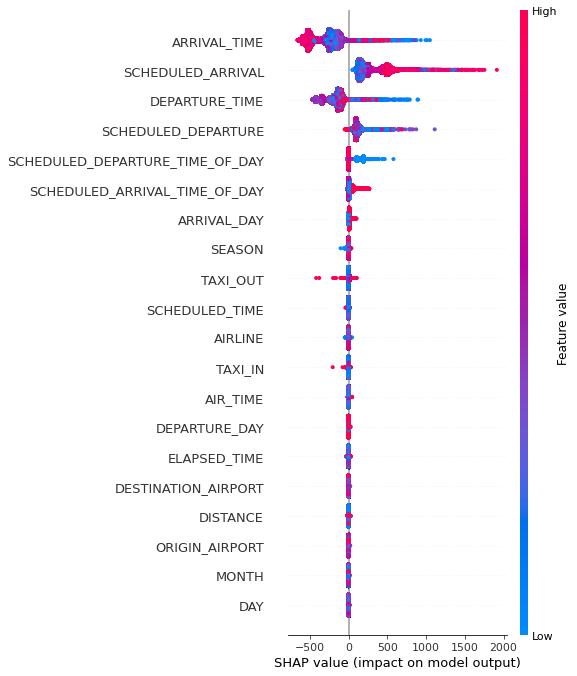

In [19]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')

# Use SHAP for model interpretation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)